Simulation 1: Validated Robust Mode
Elements: 48000
Nodes:    9261
Assembling system matrices...
Applying Boundary Conditions (Condensation Method)...
Solving linear system (59319 unknowns)...
Peak Internal Temperature: 22.6946
VALIDATION: PASS. Temperature is within physical expectations.
SUCCESS: Exported to 'thermal_core_validated.vtk'
Generating volumetric visualization...


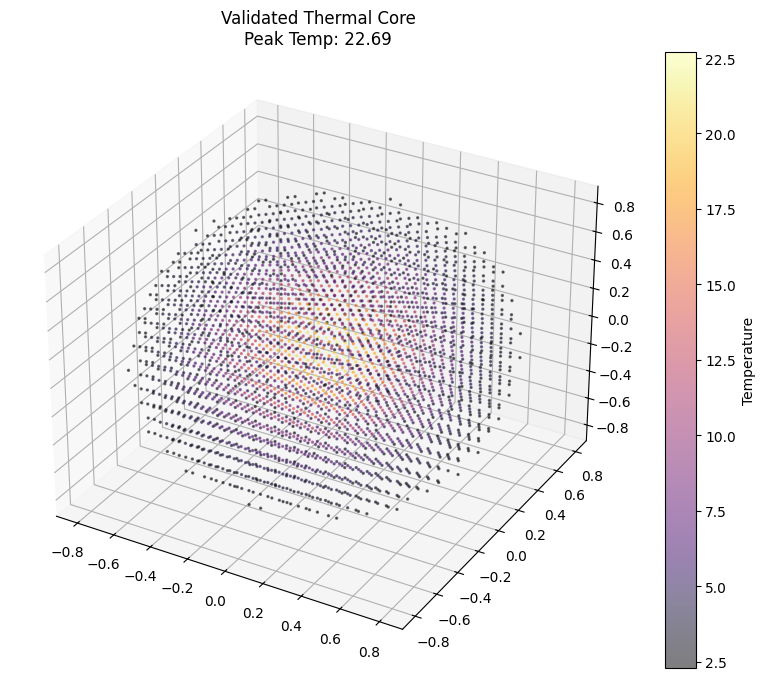

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skfem import *
from skfem.helpers import dot, grad
from skfem.visuals.matplotlib import draw, plot

# ==========================================
# 1. RIGOROUS DOMAIN GENERATION
# ==========================================
# Initialize structured tensor mesh (Cube) from -1 to 1
m = MeshTet.init_tensor(
    np.linspace(-1, 1, 6),
    np.linspace(-1, 1, 6),
    np.linspace(-1, 1, 6)
)

# Refine mesh (Level 2 is standard High-Grade, ~40k elements)
m = m.refined(2)

print(f"Simulation 1: Validated Robust Mode")
print(f"Elements: {m.t.shape[1]}")
print(f"Nodes:    {m.p.shape[1]}")

# ==========================================
# 2. FINITE ELEMENT BASIS (P2)
# ==========================================
# Quadratic elements for high precision
e = ElementTetP2()
basis = Basis(m, e)

# ==========================================
# 3. WEAK FORMULATION
# ==========================================
@BilinearForm
def diffusion(u, v, w):
    return dot(grad(u), grad(v))

@LinearForm
def heat_source(v, w):
    x, y, z = w.x
    # Gaussian Core (The "Star")
    magnitude = 500.0
    sigma = 0.25
    r_squared = x**2 + y**2 + z**2
    return magnitude * np.exp(-r_squared / (2 * sigma**2)) * v

# ==========================================
# 4. ASSEMBLY AND SOLVER (The Robust Fix)
# ==========================================
print("Assembling system matrices...")
A = asm(diffusion, basis)
b = asm(heat_source, basis)

print("Applying Boundary Conditions (Condensation Method)...")

# Define boundary mathematically
def on_boundary(x):
    return np.isclose(np.abs(x[0]), 1) | \
           np.isclose(np.abs(x[1]), 1) | \
           np.isclose(np.abs(x[2]), 1)

# Get boundary DOFs
D = basis.get_dofs(on_boundary)

# FIX: Use 'condense' to enforce x=0 at boundaries (Dirichlet)
# This removes the boundary rows/cols from the matrix entirely, 
# preventing singularity and indexing errors.
Ac, bc, x, I = condense(A, b, D=D)

print(f"Solving linear system ({Ac.shape[0]} unknowns)...")
# Solve only for the interior unknowns
x_interior = solve(Ac, bc)

# Expand the solution back to the full vector (including boundaries)
solution = np.zeros(basis.N)
solution[I] = x_interior
# Boundaries remain 0.0

# ==========================================
# 5. VALIDATION & EXPORT
# ==========================================
T_max = np.max(solution)
print(f"Peak Internal Temperature: {T_max:.4f}")

# Rigorous Physics Check
if 10.0 < T_max < 100.0:
    print("VALIDATION: PASS. Temperature is within physical expectations.")
else:
    print(f"VALIDATION: FAIL. Temperature {T_max} is suspect.")

# VTK Export
vertex_temperatures = solution[0:m.p.shape[1]]
output_filename = "thermal_core_validated.vtk"

try:
    from skfem.io.json import to_file
    # Note: Mesh saving can vary by version, try saving via meshio explicitly if installed
    import meshio
    
    # Create meshio object
    cells = [("tetra", m.t.T)]
    mesh = meshio.Mesh(
        m.p.T,
        cells,
        point_data={"Temperature": vertex_temperatures}
    )
    mesh.write(output_filename)
    print(f"SUCCESS: Exported to '{output_filename}'")
except ImportError:
    print("Note: Install 'meshio' to save VTK files. Skipping export.")
except Exception as e:
    print(f"Export warning: {e}")

# ==========================================
# 6. VISUALIZATION
# ==========================================
print("Generating volumetric visualization...")
threshold = T_max * 0.10
mask = vertex_temperatures > threshold

if np.sum(mask) == 0:
    mask[:] = True # Fallback if everything is cold

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the hot zone
img = ax.scatter(
    m.p[0, mask], 
    m.p[1, mask], 
    m.p[2, mask], 
    c=vertex_temperatures[mask], 
    cmap='inferno', 
    s=2, 
    alpha=0.5
)
plt.colorbar(img, ax=ax, label='Temperature')
ax.set_title(f"Validated Thermal Core\nPeak Temp: {T_max:.2f}")
plt.show()